In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import GPE_ensemble as GPE

from GPErks.gp.experiment import GPExperiment
from GPErks.train.emulator import GPEmulator
from GPErks.perks.inference import Inference
from GPErks.train.early_stop import NoEarlyStoppingCriterion
from GPErks.train.early_stop import (
    GLEarlyStoppingCriterion,
    PQEarlyStoppingCriterion,
    UPEarlyStoppingCriterion,
)
from GPErks.train.early_stop import PkEarlyStoppingCriterion
from GPErks.gp.data.dataset import Dataset

from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)

# Model 1: Basic GP

In [2]:
mode_weights = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

In [3]:
mode_weights

,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9,Mode10,Mode11,Mode12,Mode13,Mode14,Mode15,Mode16,Mode17,Mode18
Mesh_ID,,,,,,,,,,,,,,,,,,
1,-26.526282,-21.987510,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
2,-16.902798,23.644504,19.452896,-24.329813,-25.447350,20.415574,-8.318264,-11.552292,4.878743,-0.590770,0.058564,-5.180545,0.202458,5.183101,1.159655,-4.124027,-1.797792,1.839387
3,14.528402,16.328970,-5.269040,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703,-3.384570,6.019192,6.381015,12.668005,2.272989,-7.823127,-3.264168,-0.556074,-3.457493
4,-15.076964,28.889168,8.644859,4.758042,1.301095,5.983310,-12.741057,29.428944,0.900375,-3.117595,5.360741,-4.384879,-5.052080,-0.322429,1.764566,0.281199,0.379901,1.411104
5,-3.839848,-47.723637,7.042452,-4.914959,-4.014415,20.366371,1.061045,3.789887,-4.468229,4.581192,-5.260154,-1.138816,0.222769,-9.960540,-3.465097,8.679472,-5.080536,-3.130734
6,18.372208,-13.173184,-10.191443,-24.148353,5.156296,-5.613573,5.256249,6.128060,2.273913,-3.308190,-1.089152,5.115009,-2.514505,15.535679,-6.383510,4.925573,-2.114735,-5.143046
7,-34.355273,-16.804885,-6.838693,-12.785964,5.546781,-11.206395,-10.998304,2.434263,-4.587426,1.445966,-7.883546,-10.294014,11.979958,-1.239739,-1.025227,-5.488834,6.809864,-5.501627
8,-25.433101,7.377060,16.518874,10.553323,20.454561,-3.834116,8.557983,-6.411704,-8.757667,-9.300747,-1.650785,-11.269317,3.099298,4.335249,5.748891,3.315503,-8.408521,3.104817
9,23.260333,-15.185501,34.509394,-5.474826,-7.066281,-10.593615,5.997680,0.089632,-18.393991,4.721930,14.410537,1.322375,0.474351,-0.843182,-6.305262,-3.498095,1.827012,3.739217


In [4]:
mode_weights=mode_weights.drop(15,axis=0)
#mode_weights=mode_weights.drop(14,axis=0)

In [5]:
meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

In [6]:
pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+meshes[0]+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values

array([[0.487005, 0.321104, 6.56834 , 0.799039, 0.47051 , 5.04917 ],
       [0.649337, 0.34538 , 4.40605 , 0.311586, 0.313059, 4.37368 ],
       [0.666146, 0.43197 , 7.48917 , 0.996915, 0.20351 , 3.88357 ],
       ...,
       [0.659101, 0.299998, 1.80109 , 0.605964, 0.456326, 1.19854 ],
       [0.597605, 0.258533, 4.64056 , 0.54075 , 0.336259, 5.12383 ],
       [0.639472, 0.344217, 2.96581 , 0.654483, 0.385298, 3.01703 ]])

In [7]:
mode_weights.iloc[2,:]

Mode1     14.528402
Mode2     16.328970
Mode3     -5.269040
Mode4     31.653975
Mode5      7.173021
Mode6     17.494031
Mode7     -1.362727
Mode8     -2.515712
Mode9      3.296703
Mode10    -3.384570
Mode11     6.019192
Mode12     6.381015
Mode13    12.668005
Mode14     2.272989
Mode15    -7.823127
Mode16    -3.264168
Mode17    -0.556074
Mode18    -3.457493
Name: 3, dtype: float64

In [13]:
mode_weights.iloc[0,:].values.shape[0]

18

In [14]:
x_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\input\xlabels_EP.txt',delim_whitespace=True,header=None)
x_labels=x_labels.values.flatten().tolist()+mode_weights.columns.tolist()

In [15]:
y_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\EP_healthy\output\ylabels.txt',delim_whitespace=True,header=None)

In [11]:
len(meshes)

18

In [12]:
meshes[len(meshes)-1]

'19'

In [16]:
val=meshes[len(meshes)-1]
inputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_left_out = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
modeweights = np.tile(mode_weights.iloc[len(meshes)-1,:].values, (inputData.shape[0],1))
input_modes_left_out = np.concatenate((inputData,modeweights),axis=1)

outputData_left_out =pd.DataFrame(outputData_left_out)
input_modes_left_out = pd.DataFrame(input_modes_left_out)
input_modes_left_out.columns=x_labels
outputData_left_out.columns=y_labels

In [17]:
all_input = []
all_output=[]
for i in range(len(meshes)-1):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    modeweights = np.tile(mode_weights.iloc[i,:].values, (inputData.shape[0],1))
    input_modes = np.concatenate((inputData,modeweights),axis=1)
    all_input.append(pd.DataFrame(input_modes))
    all_output.append(pd.DataFrame(outputData))
    print(val)
    print(np.max(outputData))
all_input=pd.concat(all_input)
all_output=pd.concat(all_output)
all_input.columns=x_labels
all_output.columns=y_labels

01
406.703
02
317.407
03
332.914
04
309.14
05
277.849
06
296.377
07
355.546
08
283.103
09
391.145
10
439.316
11
348.01
12
292.465
13
301.222
14
325.678
16
297.968
17
317.709
18
297.346


In [18]:
all_input

,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB,Mode1,Mode2,Mode3,Mode4,...,Mode9,Mode10,Mode11,Mode12,Mode13,Mode14,Mode15,Mode16,Mode17,Mode18
0,0.487005,0.321104,6.56834,0.799039,0.470510,5.04917,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
1,0.649337,0.345380,4.40605,0.311586,0.313059,4.37368,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
2,0.666146,0.431970,7.48917,0.996915,0.203510,3.88357,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
3,0.564330,0.319989,4.09474,0.680346,0.313557,3.05286,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
4,0.519419,0.363704,6.37449,0.538744,0.226915,2.15749,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.450695,0.376123,4.74960,0.308837,0.347417,2.71907,-23.204781,-27.182479,-35.870687,7.551222,...,6.663375,9.520599,-1.242942,-5.988096,-3.404571,3.616827,-4.258405,-4.047239,2.077171,10.044157
176,0.532560,0.218931,3.25166,0.508092,0.341357,5.24895,-23.204781,-27.182479,-35.870687,7.551222,...,6.663375,9.520599,-1.242942,-5.988096,-3.404571,3.616827,-4.258405,-4.047239,2.077171,10.044157
177,0.529807,0.316814,3.79157,0.921791,0.247018,3.94050,-23.204781,-27.182479,-35.870687,7.551222,...,6.663375,9.520599,-1.242942,-5.988096,-3.404571,3.616827,-4.258405,-4.047239,2.077171,10.044157
178,0.536693,0.346377,4.10958,0.377127,0.319875,4.32171,-23.204781,-27.182479,-35.870687,7.551222,...,6.663375,9.520599,-1.242942,-5.988096,-3.404571,3.616827,-4.258405,-4.047239,2.077171,10.044157


In [19]:
all_output

,"(A_TAT,)","(V_TAT,)"
0,121.8820,121.3370
1,344.0830,90.1192
2,121.5100,81.1778
3,165.5310,106.5830
4,235.6170,109.6840
...,...,...
175,209.3600,111.0670
176,118.6410,111.7830
177,72.1962,100.0880
178,163.7500,95.8156


In [20]:
# split original dataset in training, validation and testing sets
X=all_input
y=all_output

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.8,
    random_state=seed
)

In [21]:
X_train

,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB,Mode1,Mode2,Mode3,Mode4,...,Mode9,Mode10,Mode11,Mode12,Mode13,Mode14,Mode15,Mode16,Mode17,Mode18
73,0.782558,0.211914,6.53354,0.580790,0.453088,1.41692,51.114176,-25.099497,-6.603593,-1.858095,...,-3.926799,3.571862,-2.670244,8.049956,2.327404,2.019624,15.558622,-7.693395,-1.831611,-0.623643
43,0.651643,0.241173,4.17709,0.635585,0.480295,2.35605,14.528402,16.328970,-5.269040,31.653975,...,3.296703,-3.384570,6.019192,6.381015,12.668005,2.272989,-7.823127,-3.264168,-0.556074,-3.457493
25,0.496883,0.390470,6.45132,0.700353,0.451937,2.12263,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
134,0.788663,0.297668,5.71884,0.753208,0.204341,1.27528,-25.433101,7.377060,16.518874,10.553323,...,-8.757667,-9.300747,-1.650785,-11.269317,3.099298,4.335249,5.748891,3.315503,-8.408521,3.104817
13,0.570864,0.431714,7.18194,0.315998,0.396939,4.52448,51.114176,-25.099497,-6.603593,-1.858095,...,-3.926799,3.571862,-2.670244,8.049956,2.327404,2.019624,15.558622,-7.693395,-1.831611,-0.623643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,0.748897,0.487695,5.88488,0.499507,0.437950,1.67314,2.227391,21.550335,14.556385,-15.904535,...,-1.214492,-8.338898,-8.695347,7.645786,-8.099683,-6.332687,-3.323418,-3.832099,5.866057,1.393940
69,0.740682,0.320987,4.13657,0.578485,0.479025,4.23699,-63.220620,18.706703,-6.052930,19.689300,...,-12.277502,4.694018,-10.464486,11.917346,-4.933180,2.092800,0.045219,-0.387472,-1.429847,-1.741355
53,0.616948,0.205457,5.05144,0.320475,0.480873,4.09542,51.114176,-25.099497,-6.603593,-1.858095,...,-3.926799,3.571862,-2.670244,8.049956,2.327404,2.019624,15.558622,-7.693395,-1.831611,-0.623643
104,0.751635,0.361058,2.94095,0.458375,0.217942,3.54476,-25.433101,7.377060,16.518874,10.553323,...,-8.757667,-9.300747,-1.650785,-11.269317,3.099298,4.335249,5.748891,3.315503,-8.408521,3.104817


In [22]:
X_train.iloc[:,0:6]

,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB
73,0.782558,0.211914,6.53354,0.580790,0.453088,1.41692
43,0.651643,0.241173,4.17709,0.635585,0.480295,2.35605
25,0.496883,0.390470,6.45132,0.700353,0.451937,2.12263
134,0.788663,0.297668,5.71884,0.753208,0.204341,1.27528
13,0.570864,0.431714,7.18194,0.315998,0.396939,4.52448
...,...,...,...,...,...,...
21,0.748897,0.487695,5.88488,0.499507,0.437950,1.67314
69,0.740682,0.320987,4.13657,0.578485,0.479025,4.23699
53,0.616948,0.205457,5.05144,0.320475,0.480873,4.09542
104,0.751635,0.361058,2.94095,0.458375,0.217942,3.54476


In [23]:
X_test

,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB,Mode1,Mode2,Mode3,Mode4,...,Mode9,Mode10,Mode11,Mode12,Mode13,Mode14,Mode15,Mode16,Mode17,Mode18
178,0.381607,0.466018,4.17615,0.921479,0.208698,3.59094,-16.902798,23.644504,19.452896,-24.329813,...,4.878743,-0.590770,0.058564,-5.180545,0.202458,5.183101,1.159655,-4.124027,-1.797792,1.839387
115,0.579746,0.318798,6.13772,0.547373,0.373423,3.51315,-63.220620,18.706703,-6.052930,19.689300,...,-12.277502,4.694018,-10.464486,11.917346,-4.933180,2.092800,0.045219,-0.387472,-1.429847,-1.741355
171,0.472671,0.466110,2.75414,0.658826,0.381194,4.43219,-63.220620,18.706703,-6.052930,19.689300,...,-12.277502,4.694018,-10.464486,11.917346,-4.933180,2.092800,0.045219,-0.387472,-1.429847,-1.741355
1,0.748597,0.345137,7.48387,0.538859,0.308420,3.45214,-15.076964,28.889168,8.644859,4.758042,...,0.900375,-3.117595,5.360741,-4.384879,-5.052080,-0.322429,1.764566,0.281199,0.379901,1.411104
78,0.444106,0.356012,7.43384,0.354421,0.424314,1.89223,-15.076964,28.889168,8.644859,4.758042,...,0.900375,-3.117595,5.360741,-4.384879,-5.052080,-0.322429,1.764566,0.281199,0.379901,1.411104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.580426,0.396937,2.67454,1.013640,0.289078,1.04889,-15.076964,28.889168,8.644859,4.758042,...,0.900375,-3.117595,5.360741,-4.384879,-5.052080,-0.322429,1.764566,0.281199,0.379901,1.411104
166,0.708928,0.338717,4.84893,0.909150,0.308233,1.64043,-12.736614,21.287883,-26.606779,-11.191512,...,4.259429,-8.376291,7.949230,-0.770768,4.035445,-7.245799,3.550741,1.498750,1.182460,-2.988593
90,0.719544,0.447575,2.73696,0.346214,0.466808,2.64924,-23.204781,-27.182479,-35.870687,7.551222,...,6.663375,9.520599,-1.242942,-5.988096,-3.404571,3.616827,-4.258405,-4.047239,2.077171,10.044157
67,0.608861,0.373363,5.96412,0.827172,0.442794,2.32105,51.114176,-25.099497,-6.603593,-1.858095,...,-3.926799,3.571862,-2.670244,8.049956,2.327404,2.019624,15.558622,-7.693395,-1.831611,-0.623643


In [24]:
GPE_mesh_original = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

0
1


TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 4
-Input parameters: ['Mode1', 'Mode2', 'Mode3', 'Mode4']
-Output size: 1
-Output feature: [array(['A_TAT'], dtype=object)]
-Sample size: 3060
-Discrepancy: 0.0505
-Validation data available: No
-Testing data available: No


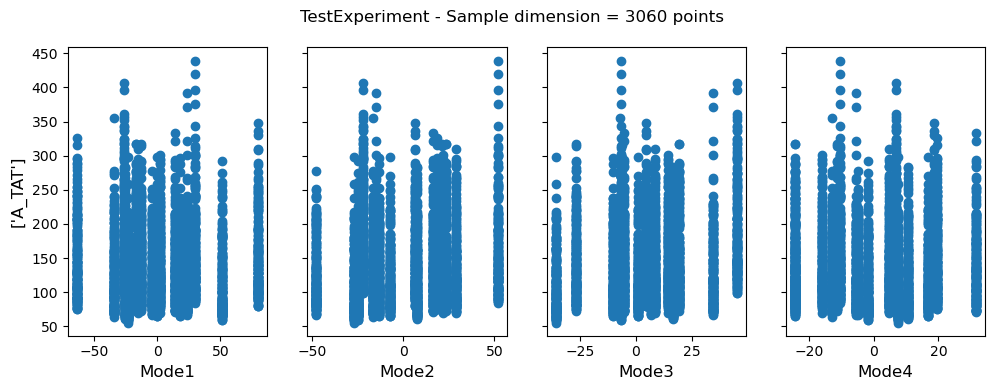

In [26]:
start=6
end=10
dataset = Dataset(
        all_input.values[:,start:end],
        all_output.iloc[:,0].values,
        x_labels=x_labels[start:end],
        y_label=y_labels.values[0],
    
        )
dataset.plot()

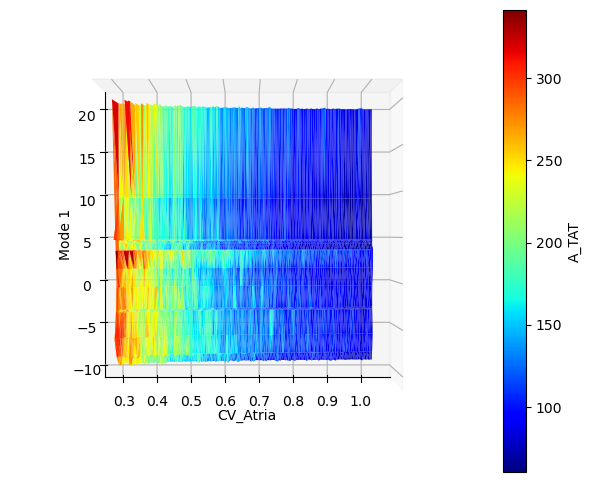

In [27]:
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy
from numpy.random import randn
from scipy import array, newaxis

# data = # your matrix here

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

surf=ax.plot_trisurf(X.iloc[:,3],X.iloc[:,15],y.iloc[:,0],cmap=cm.jet)
ax.zaxis.line.set_lw(0.)
ax.set_zticks([])
ax.set_xlabel('CV_Atria') 
ax.set_ylabel('Mode 1') 
fig.colorbar(surf,label='A_TAT')
ax.view_init(-270, -90)

In [68]:
all_input.values[:,start:end]

array([[-26.52628233, -21.98751018,  45.29867237,   6.96429709],
       [-26.52628233, -21.98751018,  45.29867237,   6.96429709],
       [-26.52628233, -21.98751018,  45.29867237,   6.96429709],
       ...,
       [-23.20478089, -27.18247875, -35.87068681,   7.55122248],
       [-23.20478089, -27.18247875, -35.87068681,   7.55122248],
       [-23.20478089, -27.18247875, -35.87068681,   7.55122248]])

In [69]:
y_train

,"(A_TAT,)","(V_TAT,)"
73,150.197,85.7102
43,131.402,110.7950
25,161.718,112.3650
134,146.342,85.1530
13,192.099,90.3625
...,...,...
21,195.411,72.0459
69,131.123,78.9679
53,182.281,110.7050
104,160.652,86.9547


In [70]:
y_test

,"(A_TAT,)","(V_TAT,)"
178,108.9460,152.0460
115,149.6710,98.7873
171,118.4760,118.9760
1,150.2590,77.7785
78,256.2360,129.9970
...,...,...
159,121.4650,100.2360
166,110.4830,81.5856
90,176.0220,67.6061
67,84.8581,90.3298


In [71]:
GPE_mesh_original.MSE(X_test,y_test)

tensor([7.6268, 2.4179], dtype=torch.float64, grad_fn=<MeanBackward1>)

In [72]:
GPE_mesh_original.R2(X_test,y_test)

tensor([0.9979, 0.9966], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [73]:
GPE_mesh_original.ISE(X_test,y_test)

tensor([95.0163, 96.1193])

In [74]:
meshes2=meshes.copy()

In [75]:
meshes2.pop(0)

'01'

In [76]:
meshes2

['02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '16',
 '17',
 '18',
 '19']

In [77]:
meshes

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '16',
 '17',
 '18',
 '19']

In [78]:
mode_weights2 = mode_weights.copy()

In [79]:
mode_weights

,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9,Mode10,Mode11,Mode12,Mode13,Mode14,Mode15,Mode16,Mode17,Mode18
Mesh_ID,,,,,,,,,,,,,,,,,,
1,-26.526282,-21.987510,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
2,-16.902798,23.644504,19.452896,-24.329813,-25.447350,20.415574,-8.318264,-11.552292,4.878743,-0.590770,0.058564,-5.180545,0.202458,5.183101,1.159655,-4.124027,-1.797792,1.839387
3,14.528402,16.328970,-5.269040,31.653975,7.173021,17.494031,-1.362727,-2.515712,3.296703,-3.384570,6.019192,6.381015,12.668005,2.272989,-7.823127,-3.264168,-0.556074,-3.457493
4,-15.076964,28.889168,8.644859,4.758042,1.301095,5.983310,-12.741057,29.428944,0.900375,-3.117595,5.360741,-4.384879,-5.052080,-0.322429,1.764566,0.281199,0.379901,1.411104
5,-3.839848,-47.723637,7.042452,-4.914959,-4.014415,20.366371,1.061045,3.789887,-4.468229,4.581192,-5.260154,-1.138816,0.222769,-9.960540,-3.465097,8.679472,-5.080536,-3.130734
6,18.372208,-13.173184,-10.191443,-24.148353,5.156296,-5.613573,5.256249,6.128060,2.273913,-3.308190,-1.089152,5.115009,-2.514505,15.535679,-6.383510,4.925573,-2.114735,-5.143046
7,-34.355273,-16.804885,-6.838693,-12.785964,5.546781,-11.206395,-10.998304,2.434263,-4.587426,1.445966,-7.883546,-10.294014,11.979958,-1.239739,-1.025227,-5.488834,6.809864,-5.501627
8,-25.433101,7.377060,16.518874,10.553323,20.454561,-3.834116,8.557983,-6.411704,-8.757667,-9.300747,-1.650785,-11.269317,3.099298,4.335249,5.748891,3.315503,-8.408521,3.104817
9,23.260333,-15.185501,34.509394,-5.474826,-7.066281,-10.593615,5.997680,0.089632,-18.393991,4.721930,14.410537,1.322375,0.474351,-0.843182,-6.305262,-3.498095,1.827012,3.739217


In [80]:
i=0

val=meshes[i]
    
print(val)

inputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_left_out = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
modeweights = np.tile(mode_weights.iloc[i,:].values, (inputData.shape[0],1))
input_modes_left_out = np.concatenate((inputData,modeweights),axis=1)

outputData_left_out =pd.DataFrame(outputData_left_out)
input_modes_left_out = pd.DataFrame(input_modes_left_out)
input_modes_left_out.columns=x_labels
outputData_left_out.columns=y_labels

all_input = []
all_output=[]

meshes2 = meshes.copy()
meshes2.pop(i)

mode_weights2 = mode_weights.copy()
mode_weights2=mode_weights2.drop(mode_weights2.index[i],axis=0)

for j in range(len(meshes)-1):

    val=meshes2[j]

    inputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    modeweights = np.tile(mode_weights2.iloc[j,:].values, (inputData.shape[0],1))
    input_modes = np.concatenate((inputData,modeweights),axis=1)
    all_input.append(pd.DataFrame(input_modes))
    all_output.append(pd.DataFrame(outputData))
    
all_input=pd.concat(all_input)
all_output=pd.concat(all_output)
all_input.columns=x_labels
all_output.columns=y_labels

03


In [81]:
mode_weights2

,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9,Mode10,Mode11,Mode12,Mode13,Mode14,Mode15,Mode16,Mode17,Mode18
Mesh_ID,,,,,,,,,,,,,,,,,,
1,-26.526282,-21.987510,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
2,-16.902798,23.644504,19.452896,-24.329813,-25.447350,20.415574,-8.318264,-11.552292,4.878743,-0.590770,0.058564,-5.180545,0.202458,5.183101,1.159655,-4.124027,-1.797792,1.839387
4,-15.076964,28.889168,8.644859,4.758042,1.301095,5.983310,-12.741057,29.428944,0.900375,-3.117595,5.360741,-4.384879,-5.052080,-0.322429,1.764566,0.281199,0.379901,1.411104
5,-3.839848,-47.723637,7.042452,-4.914959,-4.014415,20.366371,1.061045,3.789887,-4.468229,4.581192,-5.260154,-1.138816,0.222769,-9.960540,-3.465097,8.679472,-5.080536,-3.130734
6,18.372208,-13.173184,-10.191443,-24.148353,5.156296,-5.613573,5.256249,6.128060,2.273913,-3.308190,-1.089152,5.115009,-2.514505,15.535679,-6.383510,4.925573,-2.114735,-5.143046
7,-34.355273,-16.804885,-6.838693,-12.785964,5.546781,-11.206395,-10.998304,2.434263,-4.587426,1.445966,-7.883546,-10.294014,11.979958,-1.239739,-1.025227,-5.488834,6.809864,-5.501627
8,-25.433101,7.377060,16.518874,10.553323,20.454561,-3.834116,8.557983,-6.411704,-8.757667,-9.300747,-1.650785,-11.269317,3.099298,4.335249,5.748891,3.315503,-8.408521,3.104817
9,23.260333,-15.185501,34.509394,-5.474826,-7.066281,-10.593615,5.997680,0.089632,-18.393991,4.721930,14.410537,1.322375,0.474351,-0.843182,-6.305262,-3.498095,1.827012,3.739217
10,29.815137,51.794503,-6.698832,-10.525775,10.198976,-6.374325,-3.321179,-2.808528,1.829321,19.872644,-1.459484,0.886313,5.472997,-2.468306,1.051623,6.887857,-1.185734,2.101350


In [82]:
np.max(input_modes_left_out)

C:\Users\pmzcwl\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


CV_ventricles     0.799281
k_ventricles      0.498661
k_FEC             8.394630
CV_atria          1.025970
k_atria           0.499830
k_BB              5.694500
Mode1            14.528402
Mode2            16.328970
Mode3            -5.269040
Mode4            31.653975
Mode5             7.173021
Mode6            17.494031
Mode7            -1.362727
Mode8            -2.515712
Mode9             3.296703
Mode10           -3.384570
Mode11            6.019192
Mode12            6.381015
Mode13           12.668005
Mode14            2.272989
Mode15           -7.823127
Mode16           -3.264168
Mode17           -0.556074
Mode18           -3.457493
dtype: float64

In [86]:
all_input.iloc[0:180,0:16]


,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9,Mode10
0,0.487005,0.321104,6.56834,0.799039,0.470510,5.04917,-26.526282,-21.98751,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879
1,0.649337,0.345380,4.40605,0.311586,0.313059,4.37368,-26.526282,-21.98751,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879
2,0.666146,0.431970,7.48917,0.996915,0.203510,3.88357,-26.526282,-21.98751,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879
3,0.564330,0.319989,4.09474,0.680346,0.313557,3.05286,-26.526282,-21.98751,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879
4,0.519419,0.363704,6.37449,0.538744,0.226915,2.15749,-26.526282,-21.98751,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.682195,0.292650,2.03693,1.008530,0.247297,3.09133,-26.526282,-21.98751,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879
176,0.407544,0.236915,6.53663,0.463622,0.303306,2.28702,-26.526282,-21.98751,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879
177,0.659101,0.299998,1.80109,0.605964,0.456326,1.19854,-26.526282,-21.98751,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879
178,0.597605,0.258533,4.64056,0.540750,0.336259,5.12383,-26.526282,-21.98751,45.298672,6.964297,1.264487,-14.710058,2.926209,0.175002,23.694737,3.505879


In [28]:
MSE_mode = np.zeros((2,len(meshes)))
R2_mode = np.zeros((2,len(meshes)))
MSE_mode_c = np.zeros((2,len(meshes)))
R2_mode_c = np.zeros((2,len(meshes)))

MSE_leftout = np.zeros((2,len(meshes)))
MSE_leftout_c = np.zeros((2,len(meshes)))

R2_leftout = np.zeros((2,len(meshes)))
R2_leftout_c = np.zeros((2,len(meshes)))

for i in range(len(meshes)):
    
    val=meshes[i]
    
    print(val)
    
    inputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData_left_out = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    modeweights = np.tile(mode_weights.iloc[i,:].values, (inputData.shape[0],1))
    input_modes_left_out = np.concatenate((inputData,modeweights),axis=1)

    outputData_left_out =pd.DataFrame(outputData_left_out)
    input_modes_left_out = pd.DataFrame(input_modes_left_out)
    input_modes_left_out.columns=x_labels
    outputData_left_out.columns=y_labels
    
    all_input = []
    all_output=[]
    
    meshes2 = meshes.copy()
    meshes2.pop(i)
    
    mode_weights2 = mode_weights.copy()
    mode_weights2 = mode_weights2.drop(mode_weights2.index[i],axis=0)
    
    for j in range(len(meshes)-1):

        val=meshes2[j]

        inputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
        outputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
        modeweights = np.tile(mode_weights2.iloc[j,:].values, (inputData.shape[0],1))
        input_modes = np.concatenate((inputData,modeweights),axis=1)
        all_input.append(pd.DataFrame(input_modes))
        all_output.append(pd.DataFrame(outputData))
        #print(val)
        #print(np.max(outputData))
    all_input=pd.concat(all_input)
    all_output=pd.concat(all_output)
    all_input.columns=x_labels
    all_output.columns=y_labels
    
    
    # split original dataset in training, validation and testing sets
    X=all_input.iloc[:,0:15]
    y=all_output

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.5,
        random_state=seed
    )
    print(X_train.shape)
    GPE_mesh_linear = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    #GPE_mesh_constant = GPE.ensemble(X_train,y_train,mean_func="constant",training_iter=500)
    
    MSE_mode[:,i]+=GPE_mesh_linear.MSE(X_test,y_test).detach().numpy()
    R2_mode[:,i]+=GPE_mesh_linear.R2(X_test,y_test).detach().numpy()
    
    #MSE_mode_c[:,i]+=GPE_mesh_constant.MSE(X_test,y_test).detach().numpy()
    #R2_mode_c[:,i]+=GPE_mesh_constant.R2(X_test,y_test).detach().numpy()
    
    MSE_leftout[:,i]+=GPE_mesh_linear.MSE(input_modes_left_out.iloc[:,0:15],outputData_left_out).detach().numpy()
    R2_leftout[:,i]+=GPE_mesh_linear.R2(input_modes_left_out.iloc[:,0:15],outputData_left_out).detach().numpy()
    
    #MSE_leftout_c[:,i]+=GPE_mesh_constant.MSE(input_modes_left_out,outputData_left_out).detach().numpy()
    #R2_leftout_c[:,i]+=GPE_mesh_constant.R2(input_modes_left_out,outputData_left_out).detach().numpy()

01
(1530, 15)
0
1
02
(1530, 15)
0
1
03
(1530, 15)
0
1
04
(1530, 15)
0
1
05
(1530, 15)
0
1
06
(1530, 15)
0
1
07
(1530, 15)
0
1
08
(1530, 15)
0
1
09
(1530, 15)
0
1
10
(1530, 15)
0
1
11
(1530, 15)
0
1
12
(1530, 15)
0
1
13
(1530, 15)
0
1
14
(1530, 15)
0
1
16
(1530, 15)
0
1
17
(1530, 15)
0
1
18
(1530, 15)
0
1
19
(1530, 15)
0
1


In [32]:
R2_mode.T

array([[0.99933912, 0.9986782 ],
       [0.99931495, 0.99887596],
       [0.99932526, 0.99864501],
       [0.99931166, 0.99867587],
       [0.9991617 , 0.99864385],
       [0.99929205, 0.99808238],
       [0.99927557, 0.99819185],
       [0.99933392, 0.99807809],
       [0.99931665, 0.99780009],
       [0.99916274, 0.99798694],
       [0.99899425, 0.9980645 ],
       [0.99892865, 0.99786324],
       [0.9991156 , 0.99790252],
       [0.99906128, 0.99767603],
       [0.9991168 , 0.99794058],
       [0.99897365, 0.99787864],
       [0.999068  , 0.99794543],
       [0.99893196, 0.99819906]])

In [29]:
np.mean(R2_mode.T,axis=0)

array([0.99916799, 0.99817379])

In [30]:
R2_leftout.T

array([[ 0.92277907,  0.91602192],
       [ 0.08377863,  0.8562107 ],
       [ 0.82898627,  0.89998211],
       [-2.51003207,  0.87242193],
       [ 0.99225526,  0.96462761],
       [ 0.99566928,  0.99745009],
       [ 0.89887344,  0.98375902],
       [ 0.80159354,  0.9464164 ],
       [ 0.77689573,  0.81690318],
       [ 0.98507748,  0.9922672 ],
       [ 0.99100504,  0.701957  ],
       [ 0.99628865,  0.98870489],
       [ 0.86457083,  0.91937755],
       [ 0.94009053,  0.95166062],
       [ 0.96694956,  0.90519136],
       [ 0.95927189,  0.96659354],
       [ 0.9590223 ,  0.96586323],
       [ 0.97726643,  0.9698155 ]])

In [31]:
np.mean(R2_leftout.T,axis=0)

array([0.69057455, 0.92306799])

In [52]:
MSE_mode = np.zeros((2,len(meshes)-1))
R2_mode = np.zeros((2,len(meshes)-1))
MSE_mode_c = np.zeros((2,len(meshes)-1))
R2_mode_c = np.zeros((2,len(meshes)-1))

MSE_leftout = np.zeros((2,len(meshes)-1))
MSE_leftout_c = np.zeros((2,len(meshes)-1))

R2_leftout = np.zeros((2,len(meshes)-1))
R2_leftout_c = np.zeros((2,len(meshes)-1))



val=meshes[len(meshes)-1]

print(val)

inputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
outputData_left_out = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
modeweights = np.tile(mode_weights.iloc[len(meshes)-1,:].values, (inputData.shape[0],1))
input_modes_left_out = np.concatenate((inputData,modeweights),axis=1)

outputData_left_out =pd.DataFrame(outputData_left_out)
input_modes_left_out = pd.DataFrame(input_modes_left_out)
input_modes_left_out.columns=x_labels
outputData_left_out.columns=y_labels

all_input = []
all_output=[]

meshes2 = meshes.copy()
meshes2.pop(len(meshes)-1)

mode_weights2 = mode_weights.copy()
mode_weights2 = mode_weights2.drop(mode_weights2.index[len(meshes)-1],axis=0)

for i in range(17):

    all_input = []
    all_output=[]

    for j in range(i+1):

        val=meshes2[j]

        inputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
        outputData = pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
        modeweights = np.tile(mode_weights2.iloc[j,:].values, (inputData.shape[0],1))
        input_modes = np.concatenate((inputData,modeweights),axis=1)
        all_input.append(pd.DataFrame(input_modes))
        all_output.append(pd.DataFrame(outputData))
        #print(val)
        #print(np.max(outputData))
    all_input=pd.concat(all_input)
    all_output=pd.concat(all_output)
    all_input.columns=x_labels
    all_output.columns=y_labels


    # split original dataset in training, validation and testing sets
    X=all_input.iloc[:,0:15]
    y=all_output

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.5,
        random_state=seed
    )
    print(X_train.shape)
    GPE_mesh_linear = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    #GPE_mesh_constant = GPE.ensemble(X_train,y_train,mean_func="constant",training_iter=500)

    MSE_mode[:,i]+=GPE_mesh_linear.MSE(X_test,y_test).detach().numpy()
    R2_mode[:,i]+=GPE_mesh_linear.R2(X_test,y_test).detach().numpy()

    #MSE_mode_c[:,i]+=GPE_mesh_constant.MSE(X_test,y_test).detach().numpy()
    #R2_mode_c[:,i]+=GPE_mesh_constant.R2(X_test,y_test).detach().numpy()

    MSE_leftout[:,i]+=GPE_mesh_linear.MSE(input_modes_left_out.iloc[:,0:15],outputData_left_out).detach().numpy()
    R2_leftout[:,i]+=GPE_mesh_linear.R2(input_modes_left_out.iloc[:,0:15],outputData_left_out).detach().numpy()

    #MSE_leftout_c[:,i]+=GPE_mesh_constant.MSE(input_modes_left_out,outputData_left_out).detach().numpy()
    #R2_leftout_c[:,i]+=GPE_mesh_constant.R2(input_modes_left_out,outputData_left_out).detach().numpy()

19
(90, 15)
0
1
(180, 15)
0
1
(270, 15)
0
1
(360, 15)
0
1
(450, 15)
0
1
(540, 15)
0
1
(630, 15)
0
1
(720, 15)
0
1
(810, 15)
0
1
(900, 15)
0
1
(990, 15)
0
1
(1080, 15)
0
1
(1170, 15)
0
1
(1260, 15)
0
1
(1350, 15)
0
1
(1440, 15)
0
1
(1530, 15)
0
1


In [81]:
R2_leftout.T[8:18,1]

array([0.58983673, 0.98725617, 0.96829304, 0.91754101, 0.90933081,
       0.9738662 , 0.98779061, 0.97035027, 0.96927646])

In [79]:
MSE_mode.T

array([[4.38060533, 9.94411532],
       [5.87658539, 1.35486442],
       [2.81802338, 3.28353327],
       [2.38914136, 1.56551664],
       [2.93870638, 2.20957262],
       [2.47793848, 3.34648685],
       [4.127014  , 1.72201591],
       [2.50185247, 1.11322389],
       [2.59428443, 1.03893079],
       [2.20481917, 1.2140811 ],
       [2.52675451, 1.70851281],
       [2.05684156, 1.89676241],
       [3.03964471, 1.6402937 ],
       [3.10829269, 1.74103498],
       [2.29239674, 1.57345434],
       [2.79483892, 1.6808558 ],
       [3.88412725, 1.21024814]])

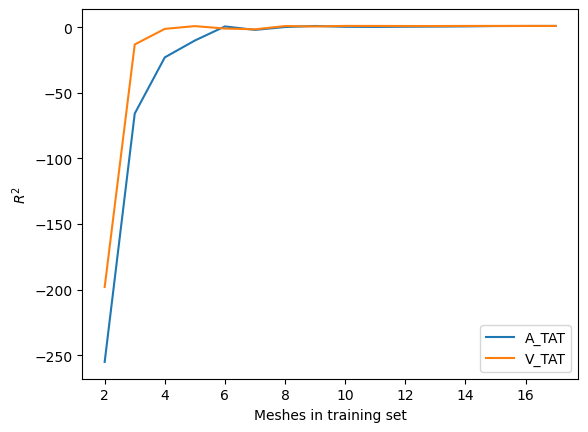

In [80]:
m_tot = np.linspace(2,17,16)
plt.plot(m_tot,R2_leftout.T[1:18,0])
plt.plot(m_tot,R2_leftout.T[1:18,1])
plt.ylabel('$R^2$')
plt.xlabel('Meshes in training set')
plt.legend(('A_TAT','V_TAT'))

In [82]:
MSE_mode = np.zeros((2,18))
R2_mode = np.zeros((2,18))
MSE_mode_c = np.zeros((2,18))
R2_mode_c = np.zeros((2,18))

MSE_leftout = np.zeros((2,18))
MSE_leftout_c = np.zeros((2,18))

R2_leftout = np.zeros((2,18))
R2_leftout_c = np.zeros((2,18))

for i in range(18):
    end = 6+i
    GPE_mesh_linear = GPE.ensemble(X_train.iloc[:,0:end],y_train,mean_func="linear",training_iter=500)
    GPE_mesh_constant = GPE.ensemble(X_train.iloc[:,0:end],y_train,mean_func="constant",training_iter=500)
    
    MSE_mode[:,i]=GPE_mesh_linear.MSE(X_test.iloc[:,0:end],y_test).detach().numpy()
    R2_mode[:,i]=GPE_mesh_linear.R2(X_test.iloc[:,0:end],y_test).detach().numpy()
    
    MSE_mode_c[:,i]=GPE_mesh_constant.MSE(X_test.iloc[:,0:end],y_test).detach().numpy()
    R2_mode_c[:,i]=GPE_mesh_constant.R2(X_test.iloc[:,0:end],y_test).detach().numpy()
    
    MSE_leftout[:,i]=GPE_mesh_linear.MSE(input_modes_left_out.iloc[:,0:end],outputData_left_out).detach().numpy()
    R2_leftout[:,i]=GPE_mesh_linear.R2(input_modes_left_out.iloc[:,0:end],outputData_left_out).detach().numpy()
    
    MSE_leftout_c[:,i]=GPE_mesh_constant.MSE(input_modes_left_out.iloc[:,0:end],outputData_left_out).detach().numpy()
    R2_leftout_c[:,i]=GPE_mesh_constant.R2(input_modes_left_out.iloc[:,0:end],outputData_left_out).detach().numpy()

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 15 but got size 16 for tensor number 1 in the list.

In [ ]:
plt.plot(R2_mode.T)

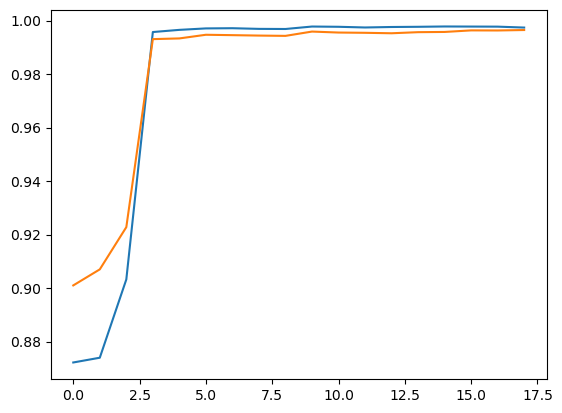

In [54]:
plt.plot(R2_mode_c.T)

In [55]:
R2_mode.T

array([[0.87334771, 0.90227103],
       [0.87547021, 0.90897829],
       [0.90385689, 0.98898123],
       [0.99609047, 0.99400564],
       [0.9967646 , 0.99417473],
       [0.99631269, 0.99488114],
       [0.99715582, 0.9948838 ],
       [0.99690641, 0.99485014],
       [0.99709282, 0.99457702],
       [0.99772753, 0.99579814],
       [0.99749528, 0.99547042],
       [0.9973391 , 0.99532893],
       [0.99772128, 0.99553714],
       [0.99762088, 0.99600096],
       [0.99779559, 0.99583721],
       [0.99786818, 0.99620531],
       [0.99786219, 0.99618227],
       [0.997644  , 0.99678959]])

In [56]:
R2_mode_c.T

array([[0.87221631, 0.90102505],
       [0.8739947 , 0.90702143],
       [0.9032577 , 0.92280382],
       [0.99573685, 0.99308617],
       [0.99654793, 0.99334856],
       [0.99709122, 0.99471567],
       [0.99716486, 0.99457092],
       [0.99691733, 0.99441297],
       [0.99687332, 0.99430086],
       [0.99779088, 0.99591138],
       [0.99769869, 0.99554648],
       [0.99744017, 0.99544734],
       [0.99762043, 0.99527729],
       [0.99769405, 0.99568479],
       [0.997814  , 0.99576902],
       [0.997781  , 0.99635169],
       [0.9977501 , 0.9963182 ],
       [0.99741003, 0.99648843]])

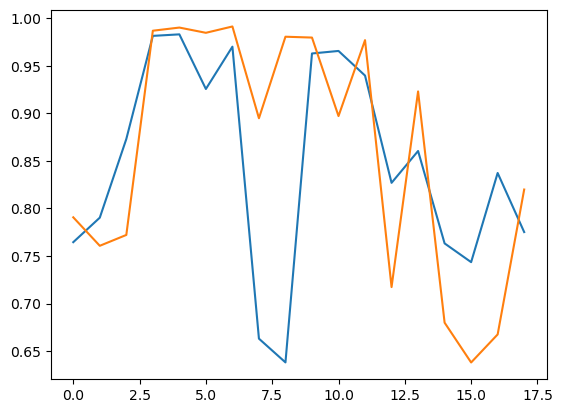

In [59]:
plt.plot(R2_leftout_c.T)

In [58]:
R2_leftout.T

array([[   0.76665045,    0.79261113],
       [   0.79389961,    0.73581677],
       [   0.8784345 ,    0.68886292],
       [   0.97399092,    0.98258928],
       [   0.98307618,    0.98692712],
       [   0.99366924,    0.99458334],
       [   0.61738507,    0.99273799],
       [   0.85039644,    0.92505106],
       [   0.88361234,    0.98875286],
       [   0.77161477,    0.96342197],
       [   0.87055207,    0.86288706],
       [   0.97778971,    0.83128866],
       [   0.82925093,    0.74082788],
       [   0.89256747,    0.88294456],
       [   0.81023086,    0.11063844],
       [   0.77752082,    0.358433  ],
       [   0.87174   ,    0.32984685],
       [-102.52790251,    0.93043077]])

In [59]:
nDim = X_train.iloc[:,0:15].shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_train.iloc[:,i]),np.max(X_train.iloc[:,i])])
    print(boundsMaxMin[i])

[0.381584, 0.7985]
[0.20144, 0.499533]
[1.21129, 8.39463]
[0.302362, 1.02988]
[0.201439, 0.499838]
[1.0121, 5.68298]
[-34.35527295, 80.11950054]
[-47.72363734, 51.79450303]
[-35.87068681, 45.29867237]
[-24.32981331, 31.65397455]
[-25.44734976, 25.6800791]
[-14.710058, 20.41557361]
[-12.74105708, 27.27330871]
[-11.55229151, 29.42894448]
[-18.39399146, 23.69473663]


In [60]:
all_input

,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB,Mode1,Mode2,Mode3,Mode4,...,Mode9,Mode10,Mode11,Mode12,Mode13,Mode14,Mode15,Mode16,Mode17,Mode18
0,0.487005,0.321104,6.56834,0.799039,0.470510,5.04917,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
1,0.649337,0.345380,4.40605,0.311586,0.313059,4.37368,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
2,0.666146,0.431970,7.48917,0.996915,0.203510,3.88357,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
3,0.564330,0.319989,4.09474,0.680346,0.313557,3.05286,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
4,0.519419,0.363704,6.37449,0.538744,0.226915,2.15749,-26.526282,-21.987510,45.298672,6.964297,...,23.694737,3.505879,0.634389,5.188583,0.952835,-1.595273,1.443640,-0.904097,-1.312873,-0.395244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.450695,0.376123,4.74960,0.308837,0.347417,2.71907,-23.204781,-27.182479,-35.870687,7.551222,...,6.663375,9.520599,-1.242942,-5.988096,-3.404571,3.616827,-4.258405,-4.047239,2.077171,10.044157
176,0.532560,0.218931,3.25166,0.508092,0.341357,5.24895,-23.204781,-27.182479,-35.870687,7.551222,...,6.663375,9.520599,-1.242942,-5.988096,-3.404571,3.616827,-4.258405,-4.047239,2.077171,10.044157
177,0.529807,0.316814,3.79157,0.921791,0.247018,3.94050,-23.204781,-27.182479,-35.870687,7.551222,...,6.663375,9.520599,-1.242942,-5.988096,-3.404571,3.616827,-4.258405,-4.047239,2.077171,10.044157
178,0.536693,0.346377,4.10958,0.377127,0.319875,4.32171,-23.204781,-27.182479,-35.870687,7.551222,...,6.663375,9.520599,-1.242942,-5.988096,-3.404571,3.616827,-4.258405,-4.047239,2.077171,10.044157


In [61]:
GPE_mesh_original = GPE.ensemble(all_input,all_output,mean_func="linear",training_iter=500)

0


KeyboardInterrupt: 

In [33]:
GPE_mesh_original?

In [34]:
x_labels

['CV_ventricles',
 'k_ventricles',
 'k_FEC',
 'CV_atria',
 'k_atria',
 'k_BB',
 'Mode1',
 'Mode2',
 'Mode3',
 'Mode4',
 'Mode5',
 'Mode6',
 'Mode7',
 'Mode8',
 'Mode9',
 'Mode10',
 'Mode11',
 'Mode12',
 'Mode13',
 'Mode14',
 'Mode15',
 'Mode16',
 'Mode17',
 'Mode18']

In [36]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
 
# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels[0:15],
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = pd.DataFrame(param_values)
data1.columns=x_labels[0:15]
data1

C:\Users\pmzcwl\AppData\Local\Temp\ipykernel_7844\1089923132.py:23: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9
0,0.380677,0.312926,4.423588,0.655339,0.367133,4.966584,-6.686810,10.733552,20.686284,13.256958,16.568013,17.654232,14.540388,2.314894,-12.824633
1,0.739882,0.312926,4.423588,0.655339,0.367133,4.966584,-6.686810,10.733552,20.686284,13.256958,16.568013,17.654232,14.540388,2.314894,-12.824633
2,0.380677,0.456429,4.423588,0.655339,0.367133,4.966584,-6.686810,10.733552,20.686284,13.256958,16.568013,17.654232,14.540388,2.314894,-12.824633
3,0.380677,0.312926,2.624783,0.655339,0.367133,4.966584,-6.686810,10.733552,20.686284,13.256958,16.568013,17.654232,14.540388,2.314894,-12.824633
4,0.380677,0.312926,4.423588,0.693113,0.367133,4.966584,-6.686810,10.733552,20.686284,13.256958,16.568013,17.654232,14.540388,2.314894,-12.824633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,0.664843,0.362420,7.128822,0.380224,0.211035,2.681945,-22.002282,-38.345219,20.765551,28.838384,-9.095560,16.385045,-12.705095,10.198980,-1.891429
32764,0.664843,0.362420,7.128822,0.380224,0.211035,2.681945,-22.002282,-38.345219,20.765551,28.838384,-9.095560,-5.808592,9.243832,10.198980,-1.891429
32765,0.664843,0.362420,7.128822,0.380224,0.211035,2.681945,-22.002282,-38.345219,20.765551,28.838384,-9.095560,-5.808592,-12.705095,28.928685,-1.891429
32766,0.664843,0.362420,7.128822,0.380224,0.211035,2.681945,-22.002282,-38.345219,20.765551,28.838384,-9.095560,-5.808592,-12.705095,10.198980,2.177696


In [37]:
Ymean_A=GPE_mesh_original.predict(data1)

In [38]:
GPE_mesh_original.training_input_STD

CV_ventricles     0.121245
k_ventricles      0.086605
k_FEC             2.078868
CV_atria          0.210743
k_atria           0.086598
k_BB              1.356759
Mode1            29.246193
Mode2            24.533744
Mode3            20.897570
Mode4            14.860222
Mode5            12.403426
Mode6            11.196664
Mode7             9.995719
Mode8             8.840723
Mode9             8.218452
dtype: float64

In [39]:
data1

,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9
0,0.380677,0.312926,4.423588,0.655339,0.367133,4.966584,-6.686810,10.733552,20.686284,13.256958,16.568013,17.654232,14.540388,2.314894,-12.824633
1,0.739882,0.312926,4.423588,0.655339,0.367133,4.966584,-6.686810,10.733552,20.686284,13.256958,16.568013,17.654232,14.540388,2.314894,-12.824633
2,0.380677,0.456429,4.423588,0.655339,0.367133,4.966584,-6.686810,10.733552,20.686284,13.256958,16.568013,17.654232,14.540388,2.314894,-12.824633
3,0.380677,0.312926,2.624783,0.655339,0.367133,4.966584,-6.686810,10.733552,20.686284,13.256958,16.568013,17.654232,14.540388,2.314894,-12.824633
4,0.380677,0.312926,4.423588,0.693113,0.367133,4.966584,-6.686810,10.733552,20.686284,13.256958,16.568013,17.654232,14.540388,2.314894,-12.824633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,0.664843,0.362420,7.128822,0.380224,0.211035,2.681945,-22.002282,-38.345219,20.765551,28.838384,-9.095560,16.385045,-12.705095,10.198980,-1.891429
32764,0.664843,0.362420,7.128822,0.380224,0.211035,2.681945,-22.002282,-38.345219,20.765551,28.838384,-9.095560,-5.808592,9.243832,10.198980,-1.891429
32765,0.664843,0.362420,7.128822,0.380224,0.211035,2.681945,-22.002282,-38.345219,20.765551,28.838384,-9.095560,-5.808592,-12.705095,28.928685,-1.891429
32766,0.664843,0.362420,7.128822,0.380224,0.211035,2.681945,-22.002282,-38.345219,20.765551,28.838384,-9.095560,-5.808592,-12.705095,10.198980,2.177696


In [40]:
data1-GPE_mesh_original.training_input_mean.T

,CV_ventricles,k_ventricles,k_FEC,CV_atria,k_atria,k_BB,Mode1,Mode2,Mode3,Mode4,Mode5,Mode6,Mode7,Mode8,Mode9
0,-0.209312,-0.037079,-0.376305,-0.009656,0.017136,1.616672,-10.531612,10.721203,19.335745,14.254826,15.256107,16.845370,13.474916,1.983788,-13.517313
1,0.149893,-0.037079,-0.376305,-0.009656,0.017136,1.616672,-10.531612,10.721203,19.335745,14.254826,15.256107,16.845370,13.474916,1.983788,-13.517313
2,-0.209312,0.106423,-0.376305,-0.009656,0.017136,1.616672,-10.531612,10.721203,19.335745,14.254826,15.256107,16.845370,13.474916,1.983788,-13.517313
3,-0.209312,-0.037079,-2.175110,-0.009656,0.017136,1.616672,-10.531612,10.721203,19.335745,14.254826,15.256107,16.845370,13.474916,1.983788,-13.517313
4,-0.209312,-0.037079,-0.376305,0.028119,0.017136,1.616672,-10.531612,10.721203,19.335745,14.254826,15.256107,16.845370,13.474916,1.983788,-13.517313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,0.074854,0.012414,2.328929,-0.284771,-0.138963,-0.667966,-25.847084,-38.357567,19.415012,29.836251,-10.407465,15.576182,-13.770567,9.867873,-2.584108
32764,0.074854,0.012414,2.328929,-0.284771,-0.138963,-0.667966,-25.847084,-38.357567,19.415012,29.836251,-10.407465,-6.617454,8.178360,9.867873,-2.584108
32765,0.074854,0.012414,2.328929,-0.284771,-0.138963,-0.667966,-25.847084,-38.357567,19.415012,29.836251,-10.407465,-6.617454,-13.770567,28.597579,-2.584108
32766,0.074854,0.012414,2.328929,-0.284771,-0.138963,-0.667966,-25.847084,-38.357567,19.415012,29.836251,-10.407465,-6.617454,-13.770567,9.867873,1.485017


In [41]:
GPE_mesh_original.training_input_mean

CV_ventricles    0.589989
k_ventricles     0.350006
k_FEC            4.799893
CV_atria         0.664995
k_atria          0.349998
k_BB             3.349912
Mode1            3.844802
Mode2            0.012349
Mode3            1.350538
Mode4           -0.997867
Mode5            1.311906
Mode6            0.808863
Mode7            1.065472
Mode8            0.331106
Mode9            0.692679
dtype: float64

In [42]:
Si_A = []
for i in range(2):
    Si_A.append(sobol.analyze(problem, Ymean_A[:,i].detach().numpy(), print_to_console=True))

                     ST   ST_conf
CV_ventricles  0.000033  0.000008
k_ventricles   0.000033  0.000009
k_FEC          0.000020  0.000005
CV_atria       0.717194  0.060974
k_atria        0.015143  0.002004
k_BB           0.106518  0.013868
Mode1          0.005248  0.000765
Mode2          0.051663  0.005701
Mode3          0.074729  0.007631
Mode4          0.001118  0.000197
Mode5          0.003091  0.000358
Mode6          0.000640  0.000113
Mode7          0.000575  0.000132
Mode8          0.019859  0.002690
Mode9          0.056465  0.005883
                     S1   S1_conf
CV_ventricles -0.000044  0.000501
k_ventricles   0.000071  0.000561
k_FEC          0.000157  0.000368
CV_atria       0.682642  0.081147
k_atria        0.009075  0.011017
k_BB           0.083672  0.030935
Mode1          0.002910  0.006460
Mode2          0.040877  0.019435
Mode3          0.061722  0.020617
Mode4         -0.000101  0.003280
Mode5          0.001925  0.005055
Mode6          0.000795  0.002283
Mode7         

In [43]:
SiZM_first=np.zeros((nDim,2))
SiZM_total=np.zeros((nDim,2))
for i in range(2):
    total_Si, first_Si, second_Si = Si_A[i].to_df()
    SiZM_first[:,i] =  first_Si.iloc[:,0]
    SiZM_total[:,i] =  total_Si.iloc[:,0]

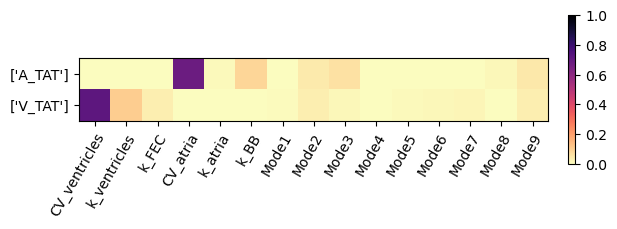

In [45]:
inputs = x_labels[0:15]
outputs = y_labels.values.tolist()
fig, ax = plt.subplots()
im = ax.imshow(SiZM_first.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)), labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [94]:
0.05*20

1.0

In [95]:
X_train.shape

(2304, 24)

In [139]:
MSE_mode = np.zeros((2,9))
R2_mode = np.zeros((2,9))
MSE_mode_c = np.zeros((2,9))
R2_mode_c = np.zeros((2,9))

MSE_leftout = np.zeros((2,9))
MSE_leftout_c = np.zeros((2,9))

R2_leftout = np.zeros((2,9))
R2_leftout_c = np.zeros((2,9))

train_size = np.zeros(9)

for i in range(9):
    
    # split original dataset in training, validation and testing sets
    X=all_input
    y=all_output

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=1-0.1*(i+1),
        random_state=seed
    )
    
    train_size[i]=X_train.shape[0]
    
    GPE_mesh_linear = GPE.ensemble(X_train.iloc[:,0:15],y_train,mean_func="linear",training_iter=500)
    #GPE_mesh_constant = GPE.ensemble(X_train.iloc[:,0:10],y_train,mean_func="constant",training_iter=500)
    
    MSE_mode[:,i]=GPE_mesh_linear.MSE(X_test.iloc[:,0:15],y_test).detach().numpy()
    R2_mode[:,i]=GPE_mesh_linear.R2(X_test.iloc[:,0:15],y_test).detach().numpy()
    
    print(R2_mode[:,i])
    
    #MSE_mode_c[:,i]=GPE_mesh_constant.MSE(X_test.iloc[:,0:10],y_test).detach().numpy()
    #R2_mode_c[:,i]=GPE_mesh_constant.R2(X_test.iloc[:,0:10],y_test).detach().numpy()
    
    MSE_leftout[:,i]=GPE_mesh_linear.MSE(input_modes_left_out.iloc[:,0:15],outputData_left_out).detach().numpy()
    R2_leftout[:,i]=GPE_mesh_linear.R2(input_modes_left_out.iloc[:,0:15],outputData_left_out).detach().numpy()
    
    #MSE_leftout_c[:,i]=GPE_mesh_constant.MSE(input_modes_left_out.iloc[:,0:10],outputData_left_out).detach().numpy()
    #R2_leftout_c[:,i]=GPE_mesh_constant.R2(input_modes_left_out.iloc[:,0:10],outputData_left_out).detach().numpy()

0
1
[0.99464999 0.99214999]
0
1
[0.99744425 0.99530271]
0
1
[0.99821485 0.99736698]
0
1
[0.9988599  0.99776436]
0
1
[0.99943397 0.99774091]
0
1
[0.9993518  0.99791052]
0
1
[0.9995565  0.99827662]
0
1
[0.99963104 0.99906153]
0
1
[0.99965936 0.99907292]


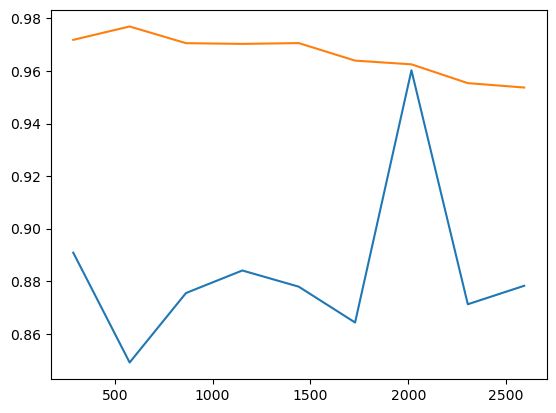

In [140]:
plt.plot(train_size,R2_leftout.T)

In [115]:
 X=all_input
y=all_output

X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.5, 
        random_state=seed
    )

In [118]:
X_train.iloc[:,[3,5,7,8,14]]

,CV_atria,k_BB,Mode2,Mode3,Mode9
47,0.404123,3.68999,-16.804885,-6.838693,-4.587426
43,0.509327,3.68630,28.889168,8.644859,0.900375
159,0.657038,2.48260,-21.987510,45.298672,23.694737
18,0.318818,3.79451,-16.804885,-6.838693,-4.587426
131,0.629641,4.52809,-21.987510,45.298672,23.694737
...,...,...,...,...,...
21,0.499507,1.67314,21.550335,14.556385,-1.214492
69,0.571060,3.22387,-7.076981,0.968164,-0.212948
53,0.320475,4.09542,-25.099497,-6.603593,-3.926799
104,0.458375,3.54476,7.377060,16.518874,-8.757667


In [133]:
GPE_mesh_ATAT = GPE.ensemble(X_train.iloc[:,[3,5,7,8,14]],y_train,mean_func="linear",training_iter=500)
GPE_mesh_VTAT = GPE.ensemble(X_train.iloc[:,[0,1,2,7,14]],y_train,mean_func="linear",training_iter=500)




0
1
0
1


In [134]:
MSE_ATAT=GPE_mesh_ATAT.MSE(X_test.iloc[:,[3,5,7,8,14]],y_test).detach().numpy()
R2_ATAT=GPE_mesh_ATAT.R2(X_test.iloc[:,[3,5,7,8,14]],y_test).detach().numpy()
MSE_ATAT_leftout=GPE_mesh_ATAT.MSE(input_modes_left_out.iloc[:,[3,5,7,8,14]],outputData_left_out).detach().numpy()
R2_ATAT_leftout=GPE_mesh_ATAT.R2(input_modes_left_out.iloc[:,[3,5,7,8,14]],outputData_left_out).detach().numpy()

MSE_VTAT=GPE_mesh_VTAT.MSE(X_test.iloc[:,[0,1,2,7,14]],y_test).detach().numpy()
R2_VTAT=GPE_mesh_VTAT.R2(X_test.iloc[:,[0,1,2,7,14]],y_test).detach().numpy()
MSE_VTAT_leftout=GPE_mesh_VTAT.MSE(input_modes_left_out.iloc[:,[0,1,2,7,14]],outputData_left_out).detach().numpy()
R2_VTAT_leftout=GPE_mesh_VTAT.R2(input_modes_left_out.iloc[:,[0,1,2,7,14]],outputData_left_out).detach().numpy()

In [135]:
R2_ATAT

array([0.98048324, 0.07070234])

In [136]:
R2_ATAT_leftout

array([-0.71665821, -0.00540869])

In [137]:
R2_VTAT

array([0.08509439, 0.99848852])

In [138]:
R2_VTAT_leftout

array([-0.16196138,  0.63364599])